In [3]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])  # Assuming many-to-one
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_(),
                  weight.new(self.num_layers, batch_size, self.hidden_size).zero_())
        return hidden

# Assuming the parameters for the LSTM model
input_size = 21
hidden_size = 128
num_layers = 3
output_size = 1

# Create an instance of LSTMModel
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)
lstm_model

LSTMModel(
  (lstm): LSTM(18, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [4]:
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
dfs = []
labels = []
pdf = pd.DataFrame()
for company in ['AAPL', 'AMD', 'AMZN', 'ASML','CSCO', 'GOOGL', 'INTC', 'MSFT', 'NVDA']:
    df_numerical = pd.read_csv('../dataset_transcript/EPS/'+company+'_EPS.csv')
    df_textural = pd.read_csv('../dataset_transcript/Transcripts/'+company+'_sentiment.csv')
    df_result = pd.read_csv('../dataset_transcript/Stock Values and Sector Index/'+company+'.csv')
    df_numerical['Date'] = pd.to_datetime(df_numerical['Date'])
    df_textural['Date'] = pd.to_datetime(df_textural['Date'])
    df_result['Date'] = pd.to_datetime(df_result['Date'])

    df_combined = pd.merge(df_textural, df_numerical, how="left", on=["Date"])

    mask = df_result['Date'].isin(df_combined['Date'])
    indices_of_interest = df_result.index[mask]
    
    previous_indices = indices_of_interest - 1
    previous_indices = previous_indices[previous_indices >= 0]
    df_previous = df_result.iloc[previous_indices].copy().reset_index(drop=True)
    df_previous = df_previous.rename(columns={col: 'prev_' + col for col in df_previous.columns})
    df_previous['Date'] = df_result.iloc[indices_of_interest].reset_index(drop=True)['Date']
    
    df_combined = pd.merge(df_combined, df_previous, how="left", on=["Date"])
    df_combined.fillna(0, inplace = True) 

    df_result = pd.merge(df_result, df_combined['Date'], how='right', on=["Date"])
    df_combined=df_combined.drop(columns=['Fiscal Quarter End', 'Date', 'prev_Date'])
    pdf=df_combined
    dfs.append(df_combined)
    labels.append(df_result['Close'])

train_size = 7
test_size = 2

train_features = torch.cat([torch.tensor(df.values).float() for df in dfs[:-test_size]])  # Assuming dfs[:-test_size] would work this way
train_labels = torch.cat([torch.tensor(label.values).float() for label in labels[:-test_size]])  # Similar handling for labels

test_features = torch.cat([torch.tensor(df.values).float() for df in dfs[-test_size:]])  # Assuming dfs[:-test_size] would work this way
test_labels = torch.cat([torch.tensor(label.values).float() for label in labels[-test_size:]])  # Similar handling for labels

train_features = train_features.view(train_size, -1, input_size)
test_features = test_features.view(test_size, -1, input_size)
train_labels = train_labels.view(train_size, -1) 
test_labels = test_labels.view(test_size, -1) 

# Create TensorDataset
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

# Create DataLoader
# Here batch_size is 1 because each batch is already pre-prepared
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # Shuffling batches, not within batches
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)  # Shuffling batches, not within batches

pdf.head()

RuntimeError: shape '[7, -1, 18]' is invalid for input of size 2793

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a function to generate predictions
def generate_predictions(data, model):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    hidden = model.init_hidden(1) 

    with torch.no_grad():  
        for i in range(data.size(0)):
            output, hidden = model(data[i:i+1].unsqueeze(0), hidden)
            hidden = (hidden[0].detach(), hidden[1].detach())  # Detach hidden state
            predictions.append(output.squeeze().item())  # Collect the prediction
    return predictions

In [ ]:
from tqdm import tqdm

def train_each_model(loader, model, optimizer, criterion, epochs):
    model.train()
    l_loss = list()
    for epoch in tqdm(range(epochs)):
        total_loss = 0

        for data, labels in loader:
            data = data.squeeze(0)  # Assuming data comes in as [1, sequence, features]
            labels = labels.squeeze(0)  # Assuming labels come in as [1, sequence]
            hidden = model.init_hidden(1) 
            for i in range(data.size(0)):  # Iterate over each time step
                optimizer.zero_grad()
                
                # Forward pass 
                output, hidden = model(data[i:i+1].unsqueeze(0), hidden)
                
                # Detach hidden states; otherwise, the graph will try to backpropagate through all previous steps
                hidden = (hidden[0].detach(), hidden[1].detach())
                
                # Compute loss
                loss = criterion(output, labels[i:i+1])
                loss.backward()  # Compute gradients
                optimizer.step()  # Update model parameters
                
                total_loss += loss.item()
        
        l_loss.append(total_loss)
        if (epoch+1) %(epochs//10) == 0:
            print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(loader)}')

    plt.plot(l_loss, linestyle='-', color='b')  
    plt.xlabel('Epochs') 
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()


def train_whole_model(loader, model, optimizer, criterion, epochs):
    model.train()
    l_loss = list()
    for epoch in tqdm(range(epochs)):
        total_loss = 0

        for data, labels in loader:
            data = data.squeeze(0)  # Assuming data comes in as [1, sequence, features]
            labels = labels.squeeze(0)  # Assuming labels come in as [1, sequence]
            hidden = model.init_hidden(1) 
            for i in range(data.size(0)):  # Iterate over each time step
                optimizer.zero_grad()
                
                # Forward pass 
                output, hidden = model(data[i:i+1].unsqueeze(0), hidden)
                
                # Detach hidden states; otherwise, the graph will try to backpropagate through all previous steps
                hidden = (hidden[0].detach(), hidden[1].detach())
                
                # Compute loss
                loss = criterion(output, labels[i:i+1])
                total_loss += loss

        total_loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters
        
        l_loss.append(total_loss.item())
        if (epoch+1) %(epochs//10) == 0:
            print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(loader)}')

    plt.plot(l_loss, linestyle='-', color='b')  
    plt.xlabel('Epochs') 
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]/Users/jiaruiz/miniforge3/envs/6998/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 5/50 [00:01<00:15,  2.82it/s]

Epoch 5, Average Loss: 7663007.698856167


 20%|██        | 10/50 [00:03<00:12,  3.23it/s]

Epoch 10, Average Loss: 7350652.172621931


 30%|███       | 15/50 [00:04<00:09,  3.62it/s]

Epoch 15, Average Loss: 7303297.688945225


 40%|████      | 20/50 [00:05<00:08,  3.64it/s]

Epoch 20, Average Loss: 7287273.711565291


 50%|█████     | 25/50 [00:07<00:06,  3.68it/s]

Epoch 25, Average Loss: 7291920.43711635


 60%|██████    | 30/50 [00:08<00:05,  3.73it/s]

Epoch 30, Average Loss: 7315685.425362723


 70%|███████   | 35/50 [00:09<00:04,  3.74it/s]

Epoch 35, Average Loss: 7311063.815046038


 80%|████████  | 40/50 [00:11<00:02,  3.65it/s]

Epoch 40, Average Loss: 7296937.676443918


 90%|█████████ | 45/50 [00:12<00:01,  3.73it/s]

Epoch 45, Average Loss: 7302193.719412668


100%|██████████| 50/50 [00:13<00:00,  3.58it/s]

Epoch 50, Average Loss: 7410210.89188058


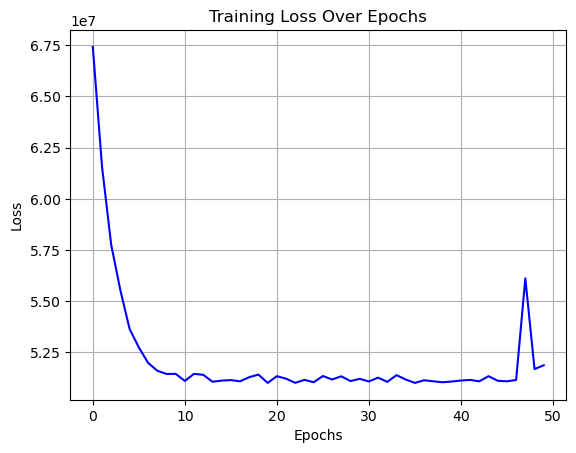

 11%|█         | 11/100 [00:01<00:08, 10.16it/s]

Epoch 10, Average Loss: 7272361.5


 21%|██        | 21/100 [00:02<00:07, 10.52it/s]

Epoch 20, Average Loss: 7235206.5


 31%|███       | 31/100 [00:03<00:06, 10.48it/s]

Epoch 30, Average Loss: 7203754.5


 41%|████      | 41/100 [00:04<00:05, 10.56it/s]

Epoch 40, Average Loss: 7203267.5


 51%|█████     | 51/100 [00:04<00:04, 10.40it/s]

Epoch 50, Average Loss: 7203235.0


 61%|██████    | 61/100 [00:05<00:03, 10.33it/s]

Epoch 60, Average Loss: 7203236.0


 71%|███████   | 71/100 [00:06<00:02, 10.38it/s]

Epoch 70, Average Loss: 7203223.0


 81%|████████  | 81/100 [00:07<00:01, 10.40it/s]

Epoch 80, Average Loss: 7203218.5


 91%|█████████ | 91/100 [00:08<00:00, 10.59it/s]

Epoch 90, Average Loss: 7203213.0


100%|██████████| 100/100 [00:09<00:00, 10.30it/s]

Epoch 100, Average Loss: 7203209.0


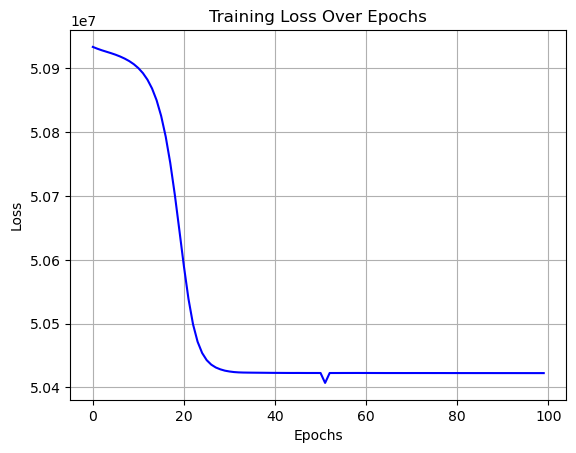

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)
train_each_model(train_loader, lstm_model, optimizer, criterion, epochs=50)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)
train_whole_model(train_loader, lstm_model, optimizer, criterion, epochs=100)

 10%|█         | 50/500 [00:13<02:01,  3.72it/s]

Epoch 50, Average Loss: 7217254.136404855


 20%|██        | 100/500 [00:25<01:25,  4.70it/s]

Epoch 100, Average Loss: 7213176.705862863


 30%|███       | 150/500 [00:36<01:11,  4.93it/s]

Epoch 150, Average Loss: 7219026.584629604


 40%|████      | 201/500 [00:46<00:59,  5.00it/s]

Epoch 200, Average Loss: 7215615.79347447


 50%|█████     | 250/500 [00:56<00:51,  4.81it/s]

Epoch 250, Average Loss: 7215286.65511649


 60%|██████    | 300/500 [01:09<00:51,  3.88it/s]

Epoch 300, Average Loss: 7216808.15359933


 70%|███████   | 350/500 [01:23<00:39,  3.76it/s]

Epoch 350, Average Loss: 7217195.79045759


 80%|████████  | 400/500 [01:36<00:25,  3.85it/s]

Epoch 400, Average Loss: 7218608.164882115


 90%|█████████ | 450/500 [01:49<00:13,  3.81it/s]

Epoch 450, Average Loss: 7215220.39479283


100%|██████████| 500/500 [02:02<00:00,  4.07it/s]

Epoch 500, Average Loss: 7212784.859915597


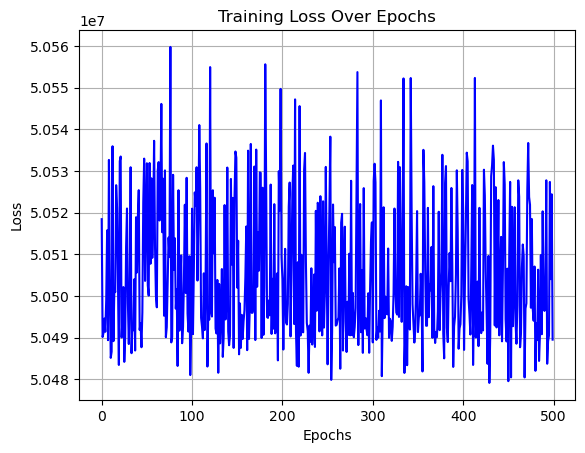

 10%|█         | 102/1000 [00:09<01:24, 10.65it/s]

Epoch 100, Average Loss: 7203212.5


 20%|██        | 202/1000 [00:18<01:14, 10.70it/s]

Epoch 200, Average Loss: 7203192.0


 30%|███       | 302/1000 [00:28<01:04, 10.79it/s]

Epoch 300, Average Loss: 7202140.5


 40%|████      | 402/1000 [00:38<00:55, 10.85it/s]

Epoch 400, Average Loss: 7202073.0


 50%|█████     | 502/1000 [00:47<00:49, 10.11it/s]

Epoch 500, Average Loss: 7202018.5


 60%|██████    | 602/1000 [00:57<00:39, 10.16it/s]

Epoch 600, Average Loss: 7201969.5


 70%|███████   | 702/1000 [01:07<00:29, 10.22it/s]

Epoch 700, Average Loss: 7201922.5


 80%|████████  | 802/1000 [01:16<00:19, 10.41it/s]

Epoch 800, Average Loss: 7201877.5


 90%|█████████ | 902/1000 [01:26<00:09, 10.48it/s]

Epoch 900, Average Loss: 7201834.5


100%|██████████| 1000/1000 [01:35<00:00, 10.42it/s]

Epoch 1000, Average Loss: 7201789.5


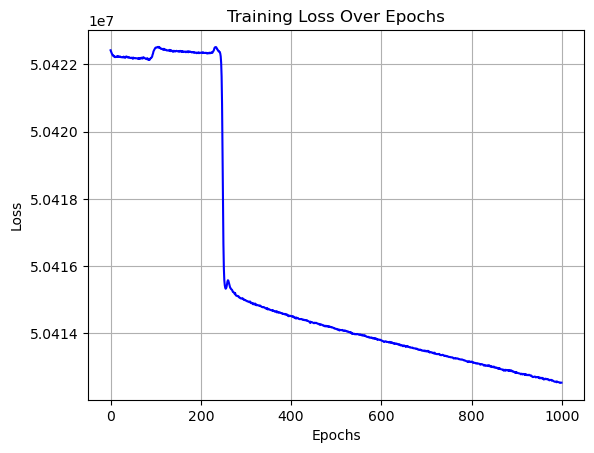

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
train_each_model(train_loader, lstm_model, optimizer, criterion, epochs=500)

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
train_whole_model(train_loader, lstm_model, optimizer, criterion, epochs=1000)

In [ ]:
import numpy as np
def binary_accuracy(predict, truth):
    diff1 = np.array(predict[1:])-np.array(predict[:-1])
    y_prediction = diff1 / np.abs(diff1)
    diff2 = np.array(truth[1:])-np.array(truth[:-1])
    truth_labels = diff2/ np.abs(diff2)

    negative = -1.0
    positive = 1.0

    tp = np.sum(np.logical_and(y_prediction == positive, truth_labels == positive))
    tn = np.sum(np.logical_and(y_prediction == negative, truth_labels == negative))
    fp = np.sum(np.logical_and(y_prediction == positive, truth_labels == negative))
    fn = np.sum(np.logical_and(y_prediction == negative, truth_labels == positive))
    s = tp+tn+fp+fn
    return tp/s, tn/s, fp/s, fn/s

In [ ]:
for data, labels in train_loader:
    train_predictions = generate_predictions(data.view(-1, input_size), lstm_model)
    # Convert train_labels to a list or a numpy array if it's a tensor
    train_labels_list = labels.squeeze().tolist()  # Adjust based on your actual format
    tp, tn, fp, fn = binary_accuracy(train_predictions, train_labels_list)
    print("true increase: ", tp, "true decrease: ", tn, "false increase: ", fp,"false decrease: ", fn)

    # Plot the actual and predicted values
    plt.plot(train_labels_list, marker='x', label='Actual Training Labels')
    plt.plot(train_predictions, marker='x', label='Predicted Training Labels', alpha=0.7)
    plt.title('Comparison of Actual and Predicted Training Labels')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

NameError: name 'train_loader' is not defined

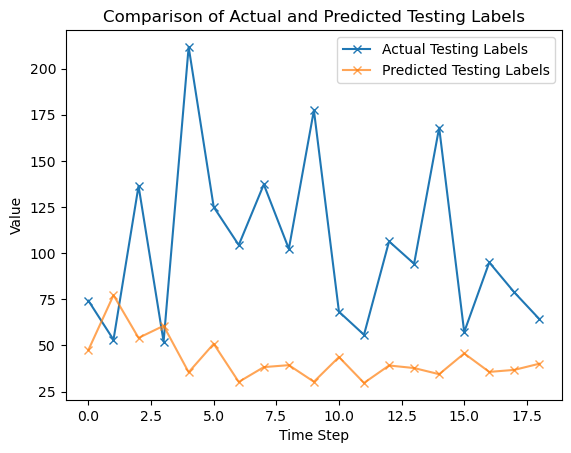

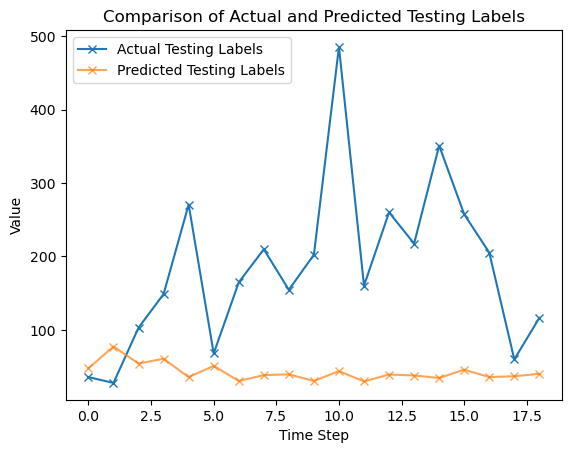

In [ ]:
for data, labels in test_loader:
    test_predictions = generate_predictions(data.view(-1, 21), lstm_model)
    # Convert train_labels to a list or a numpy array if it's a tensor
    test_labels_list = labels.squeeze().tolist()  # Adjust based on your actual format
    tp, tn, fp, fn = binary_accuracy(test_predictions, test_labels_list)
    print("true increase: ", tp, "true decrease: ", tn, "false increase: ", fp,"false decrease: ", fn)

    # Plot the actual and predicted values
    plt.plot(test_labels_list, marker='x', label='Actual Testing Labels')
    plt.plot(test_predictions, marker='x', label='Predicted Testing Labels', alpha=0.7)
    plt.title('Comparison of Actual and Predicted Testing Labels')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()